# Example 10.8

Exact Solution at (x=1) = 3.436564
Euler Solution:
x = 0.0, y = 1.000000
x = 0.1, y = 1.100000
x = 0.2, y = 1.220000
x = 0.3, y = 1.362000
x = 0.4, y = 1.528200
x = 0.5, y = 1.721020
x = 0.6, y = 1.943122
x = 0.7, y = 2.197434
x = 0.8, y = 2.487178
x = 0.9, y = 2.815895
x = 1.0, y = 3.187485


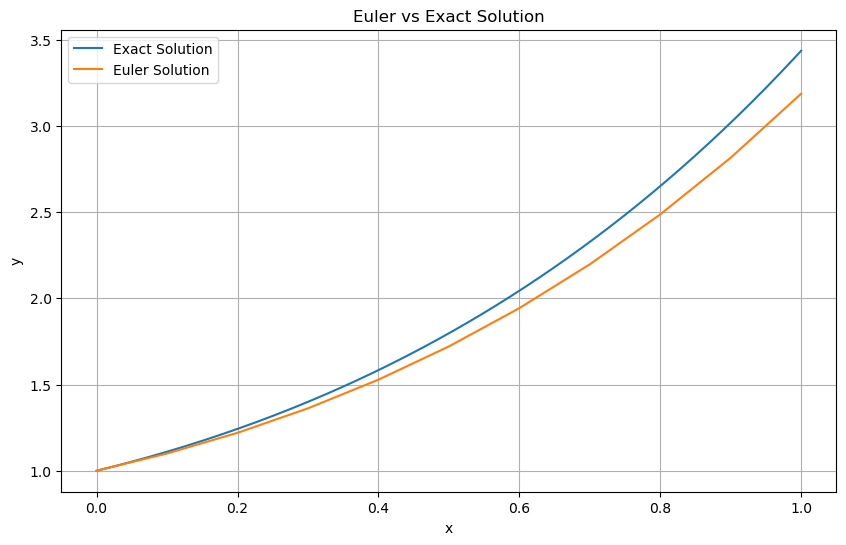

In [7]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x), x + y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
exact_func = sp.lambdify(x, sol.rhs, 'numpy')
print(f'Exact Solution at (x=1) = {sol.rhs.subs(x, 1):.6f}')

f = lambda x, y: x + y

def euler(f, x0, y0, xn, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y = y + h * f(x, y)
        x = x + h
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)
xs, ys = euler(f, 0, 1, 1, 10, 0.1)
print('Euler Solution:')
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x_vals = np.linspace(0, 1, 200)
exact_vals = exact_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, label='Exact Solution')
plt.plot(xs, ys, label='Euler Solution')
plt.title('Euler vs Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ===================================
# PINN for Example 10.8
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - y - x_colloc
    loss_pde = torch.mean(f**2)
    
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

# Predictions
x_vals_torch = torch.tensor(xs.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn = model(x_vals_torch).detach().cpu().numpy().flatten()

print('\nComparison at x=1.0:')
print(f'Euler: {ys[-1]:.6f}, Exact: {exact_func(1.0):.6f}, PINN: {y_pinn[-1]:.6f}')

# ===================================
# Enhanced Plot with PINN
# ===================================
x_plot = np.linspace(0, 1, 200)
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.plot(x_vals, exact_vals, 'k-', label='Exact Solution', linewidth=2)
plt.plot(xs, ys, 'bo-', label='Euler Solution', markersize=6, linewidth=2)
plt.plot(x_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Euler vs Exact vs PINN Solution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Example 10.9

Given $\frac{dy}{dx} = \frac{y - x}{y + x}$ with the initial condition $y(0) = 1$ Use **Euler’s method** to approximate the value of $y$ at $x = 0.1$

In [9]:
f = lambda x, y: (y - x) / (y + x)

def euler3(f, x0, y0, n, h):

    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y = y + h * f(x, y)
        x = x + h
        xs.append(x)
        ys.append(y)

    return xs, ys
xs, ys = euler3(f, 0, 1, 5, 0.02)
print(xs)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.2f}, y = {yi:.6f}')

[0, 0.02, 0.04, 0.06, 0.08, 0.1]
x = 0.00, y = 1.000000
x = 0.02, y = 1.020000
x = 0.04, y = 1.039231
x = 0.06, y = 1.057748
x = 0.08, y = 1.075601
x = 0.10, y = 1.092832


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ===================================
# PINN for Example 10.9
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(0, 0.1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - (y - x_colloc) / (y + x_colloc + 1e-8)
    loss_pde = torch.mean(f**2)
    
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.tensor([[0.1]], dtype=torch.float32, device=device)
y_pinn = model(x_pinn).detach().cpu().numpy()[0, 0]

print(f'\nPINN Solution at x=0.1: {y_pinn:.6f}')
print(f'Euler Solution at x=0.1: {ys[-1]:.6f}')

# ===================================
# Plot
# ===================================
x_plot = np.linspace(0, 0.1, 200)
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy().flatten()

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'bo-', label='Euler Solution', markersize=6, linewidth=2)
plt.plot(x_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Euler vs PINN (Example 10.9)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Example 10.10
Using **modified Euler's method**, find an approximate value of y when when x = 0.3, given that $\frac{dy}{dx} = x + y$ and y = 1 when x = 0

In [12]:
f = lambda x, y: x + y

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        y = y_new
        x = x_next
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 1, 3, 0.1, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.4f}')

x = 0.0, y = 1.0000
x = 0.1, y = 1.1105
x = 0.2, y = 1.2432
x = 0.3, y = 1.4004


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ===================================
# PINN for Example 10.10 (Modified Euler)
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_me = PINN().to(device)

x_colloc = torch.linspace(0, 0.3, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model_me(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - y - x_colloc
    loss_pde = torch.mean(f**2)
    
    y0_pred = model_me(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model_me.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model_me.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.tensor([[0.3]], dtype=torch.float32, device=device)
y_pinn = model_me(x_pinn).detach().cpu().numpy()[0, 0]

print(f'\nPINN Solution at x=0.3: {y_pinn:.6f}')
print(f'Modified Euler at x=0.3: {ys[-1]:.6f}')

# ===================================
# Plot
# ===================================
x_plot = np.linspace(0, 0.3, 200)
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn_plot = model_me(x_plot_torch).detach().cpu().numpy().flatten()

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'go-', label='Modified Euler', markersize=6, linewidth=2)
plt.plot(x_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Modified Euler vs PINN (Example 10.10)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Example 10.11

In [18]:
from math import exp
f = lambda x, y: y + exp(x)

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h

        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 0, 2, 0.2, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')


x = 0.0, y = 0.000000
x = 0.2, y = 0.246822
x = 0.4, y = 0.603142


# Example 10.12

In [21]:
from math import log

f = lambda x, y: log(x + y)

def modified_euler(f, x0, y0, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    n = 7

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h

        y_old = y_pred

        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 2, 0.2, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.2f}, y = {yi:.6f}')

x = 0.00, y = 2.000000
x = 0.20, y = 2.154967
x = 0.40, y = 2.341469
x = 0.60, y = 2.557290
x = 0.80, y = 2.800365
x = 1.00, y = 3.068804
x = 1.20, y = 3.360890
x = 1.40, y = 3.675076


# Example 10.13

In [3]:
import math

f = lambda x, y: x + abs(math.sqrt(y))

def modified_euler(f, x0, y0, h, tol):

    xs =[x0]
    ys = [y0]
    x = x0
    y = y0
    n = 3

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h

        y_old = y_pred

        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 1, 0.2, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.4f}')

x = 0.0, y = 1.0000
x = 0.2, y = 1.2309
x = 0.4, y = 1.5254
x = 0.6, y = 1.8863


# Exercise 10.2.1

In [16]:
f = lambda x, y: x + y

def euler(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y = y + h * f(x, y)
        x = x + h

        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = euler(f, 0, 0, 6, 0.2)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.2f}, y = {yi:.6f}')

x = 0.00, y = 0.000000
x = 0.20, y = 0.000000
x = 0.40, y = 0.040000
x = 0.60, y = 0.128000
x = 0.80, y = 0.273600
x = 1.00, y = 0.488320
x = 1.20, y = 0.785984


# Exercise 10.2.2

In [15]:
f = lambda x, y: 1 - 2*x*y

def euler(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y = y + h * f(x, y)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = euler(f, 0, 0, 3, 0.2)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 0.000000
x = 0.2, y = 0.200000
x = 0.4, y = 0.384000
x = 0.6, y = 0.522560


# Exercise 10.2.3

In [17]:
f = lambda x, y: x + y + x*y

def euler(f, x0, y0, n, h):

    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y = y + h * f(x, y)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = euler(f, 0, 1, 4, 0.025)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.3f}, y = {yi:.6f}')

x = 0.000, y = 1.000000
x = 0.025, y = 1.025000
x = 0.050, y = 1.051891
x = 0.075, y = 1.080753
x = 0.100, y = 1.111673


# Exercise 10.2.4

In [19]:
f = lambda x, y: 1 - y

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 0, 3, 0.1, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 0.000000
x = 0.1, y = 0.095238
x = 0.2, y = 0.181406
x = 0.3, y = 0.259367


# Exercise 10.2.5

In [22]:
f = lambda x, y: x**2 + y

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 1, 2, 0.05, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.2f}, y = {yi:.6f}')

x = 0.00, y = 1.000000
x = 0.05, y = 1.051346
x = 0.10, y = 1.105582


# Exercise 10.2.6

In [24]:
import math
f = lambda x, y: x + math.sin(y)

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 1, 2, 0.2, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 1.000000
x = 0.2, y = 1.197251
x = 0.4, y = 1.449622


# Exercise 10.2.7

In [26]:
f = lambda x, y: (y - x) / (y + x)

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 0, 1, 5, 0.02, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.2f}, y = {yi:.6f}')

x = 0.00, y = 1.000000
x = 0.02, y = 1.019615
x = 0.04, y = 1.038489
x = 0.06, y = 1.056672
x = 0.08, y = 1.074211
x = 0.10, y = 1.091146


# Exercise 10.2.8

In [27]:
import math
f = lambda x, y: 2 + math.sqrt(x*y)

def modified_euler(f, x0, y0, n, h, tol):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    for i in range(n):
        y_pred = y + h * f(x, y)
        x_next = x + h
        y_old = y_pred
        while True:
            y_new = y + (h/2)*(f(x, y) + f(x_next, y_old))
            if abs(y_new - y_old) < tol:
                break
            y_old = y_new
        x = x_next
        y = y_new
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = modified_euler(f, 1, 1, 5, 0.2, 1e-6)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 1.0, y = 1.000000
x = 1.2, y = 1.640298
x = 1.4, y = 2.362460
x = 1.6, y = 3.169518
x = 1.8, y = 4.065219
x = 2.0, y = 5.053645
